In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from itertools import combinations

In [ ]:
p = pd.read_json("pftrain2.jsonl", orient='records', lines=True)

In [2]:
test_df = pd.read_json("output/testsetlarge.jsonl", lines=True, orient="records")
# crafted to not include stuff from earlier training
train_df = pd.read_json("output/trainsetlarge.jsonl", lines=True, orient="records")

In [10]:
train_df['dist'] = (train_df.score_a-train_df.score_b).abs()
test_df['dist'] = (test_df.score_a-test_df.score_b).abs()

In [13]:
train_df = train_df[train_df.dist>0.05]
test_df = test_df[test_df.dist>0.05]

(array([8.5606e+04, 4.5215e+04, 2.3596e+04, 1.1905e+04, 5.7720e+03,
        2.6680e+03, 1.1490e+03, 3.5700e+02, 8.2000e+01, 1.4000e+01]),
 array([0.05000001, 0.136257  , 0.22251398, 0.30877097, 0.39502795,
        0.48128494, 0.56754192, 0.6537989 , 0.74005589, 0.82631287,
        0.91256986]),
 <BarContainer object of 10 artists>)

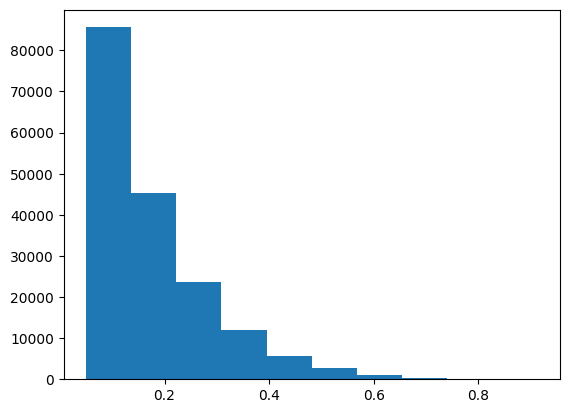

In [18]:
plt.hist(train_df.dist)

In [14]:
train_df.to_json("output/trainsetbalanced.jsonl", lines=True, orient="records")
test_df.to_json("output/testsetbalanced.jsonl", lines=True, orient="records")

In [22]:
# A, B, C, D
# CLASSES = [71, 272, 205, 309]
CLASSES = [71, 272]
def getclass(val):
    if val<0.65:
        return CLASSES[0]
    elif val<0.75:
        return CLASSES[1]
    elif val<0.85:
        return CLASSES[2]
    else:
        return CLASSES[3]
    
def pairlabel(val):
    if val==1:
        return CLASSES[0]
    return CLASSES[1]

In [ ]:
train_df['label'] = [getclass(v) for v in train_df['sco']]
test_df['label'] = [getclass(v) for v in test_df['sco']]

In [ ]:
train_df.to_json("output/trainsetlarge.jsonl", lines=True, orient="records")
test_df.to_json("output/testsetlarge.jsonl", lines=True, orient="records")

In [ ]:
len(p['inp'].unique())

In [ ]:
groups = []
lens = set()
shown = 0
for _, d in prefdataset.groupby('inp'):
    if len(d)==6:
        groups.append(d)
    else:
        if shown<8:
            print(d)
            shown = shown+1

In [4]:
# process raw data into single uniform file
base = "output/rawdata/"
allfiles = [
    "bigdsetp1",
    "bigdsetp2",
    "bigdsetp3",
    "bigdsetp4",
    "bigdsetp5",
    "biggerdset",
    "biggerdset2",
    "biggerdset3",
    "biggerdset4",
    "biggerdset6",
    
]
fulldset = pd.concat([pd.read_json(base+f+".jsonl", orient='records', lines=True) for f in allfiles])
fulldset = fulldset[fulldset['ver']=='first'].drop(columns=['stats', 'ver', 'pref', 'prefix']).reset_index(drop=True)

In [ ]:
def random_prefix_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    new_rows = []
    forbatch = []
    skipped = 0
    for index, row in df.iterrows():
        input_str = row['inp']
        # batches of 3 for consistency
        hyps = row['hyps'][:3]
        scos = row['scos'][:3]
        assert len(hyps)==3
        # get more than 1 prefix per example for robustness
        added = 0
        while added<6:
            for hyp, sco in zip(hyps, scos):
                words = hyp.split(' ')
                if len(words)<=3:
                    skipped = skipped+1
                    continue
                prefix_length = random.randint(3, min(len(words), 25))
                prefix = ' '.join(words[:prefix_length])

                new_row = {
                    'inp': input_str,
                    'hyp': prefix,
                    'pflen':prefix_length,
                    'sco': sco
                }
                new_rows.append(new_row)
                added = added+1

    print(added)
    print(skipped)
    new_df = pd.DataFrame(new_rows)
    return new_df



df = pd.DataFrame({
    'inp': ['input1', 'input2', 'input3'],
    'hyps': [['hyp1 word1 word2', 'hyp2 word1 word2', 'hyp3 word1 word2'],
             ['hyp4 word1 word2', 'hyp5 word1 word2', 'hyp6 word1 word2'],
             ['hyp7 word1 word2', 'hyp8 word1 word2', 'hyp9 word1 word2']],
    'scos': [[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 0.9]],
})

# Function to construct a DataFrame with pairs
def construct_pair_dset(row, k):
    all_pairs = list(combinations(range(len(row['hyps'])), 2))
    pairs_indices = random.choices(all_pairs, k=k)  # sample n unique pairs
    pairs = [(row['hyps'][i], row['hyps'][j]) for i, j in pairs_indices]
    scores = [(row['scos'][i], row['scos'][j]) for i, j in pairs_indices]
    
    # Truncate pairs to 5 to 25 words
    truncated_pairs = []
    deleted = []
    for i in range(len(pairs)):
        pair = pairs[i]
        splits = [hyp.split() for hyp in pair]
        try:
            truncation = random.randint(5, min(25, min([len(arr) for arr in splits])))
            truncated_pair = []
            for hyp in pair:
                words = hyp.split()
                truncated_words = words[:min(truncation, len(words))]
                truncated_hyp = ' '.join(truncated_words)
                truncated_pair.append(truncated_hyp)
            truncated_pairs.append(tuple(truncated_pair))
        except:
            print("bad pair")
            deleted.append(i)

    fscores = []
    for i in range(len(pairs)):
        if i not in deleted:
            fscores.append(scores[i])

    label = [score_a > score_b for score_a, score_b in fscores]
    df_temp = pd.DataFrame({'inp': row['inp'], 'hyp_pairs': truncated_pairs,
                            'score_a': [s[0] for s in fscores],
                            'score_b': [s[1] for s in fscores],
                            'label': label})
    return df_temp

k=5
# Create the new DataFrame
df_new = pd.concat([construct_pair_dset(row, k) for _,row in fulldset.iterrows()]).reset_index(drop=True)

# Optionally, split the 'hyp_pairs' column into 'hyp_a' and 'hyp_b'
df_new[['hyp_a', 'hyp_b']] = pd.DataFrame(df_new['hyp_pairs'].tolist(), index=df_new.index)
df_new = df_new.drop('hyp_pairs', axis=1)

In [23]:
df_new['numlab'] = df_new.label

In [24]:
df_new['label'] = [pairlabel(p) for p in df_new.numlab]

In [30]:
trainset = df_new.iloc[:250000]
testset = df_new.iloc[250000:]

In [7]:
fulldset = fulldset.drop_duplicates(subset=['inp'])

In [ ]:
prefdataset = random_prefix_dataframe(fulldset)
prefdataset['label']=(prefdataset.sco>0.85).astype(int)

In [ ]:
len(prefdataset)/len(prefdataset['inp'].unique())

In [ ]:
int((len(prefdataset)/6)*.9)

In [ ]:
trainset = prefdataset.iloc[:49687*6]

In [ ]:
testset = prefdataset.iloc[49687*6:]

In [33]:
trainset.to_json("output/trainsetlarge.jsonl", orient="records", lines=True)

In [34]:
testset.to_json("output/testsetlarge.jsonl", orient="records", lines=True)

In [ ]:
prefdataset.to_json("output/largerpfmdataset.jsonl", orient="records", lines=True)

In [ ]:
prefdataset = pd.read_json("output/prefmetricdataset.jsonl", orient="records", lines=True)
test_exs = pd.read_json("pftest.jsonl", orient="records", lines=True)

In [ ]:
test_exs

In [ ]:
merged_df = prefdataset.merge(test_exs, indicator=True, how='outer')
train_df = merged_df[merged_df['_merge'] == 'left_only'].reset_index(drop=True)

In [ ]:
train_df.to_json("pftrain.jsonl", orient='records', lines=True)

In [ ]:
train_df